# Introduction and goals #

This file is suppused contain code to calculate the LCL, CCL and LFC and whether an air parcel will reach these states. As a first start the analysis is executed at the same location as the El Arish radiosonde station. This will make it possible to compare the results with observations and givw an impression of how feasable this kind of analysis is with the data resolution that is available. Starting for one day with clouds, continueing to extra days without clouds. For the days without clouds the goal is to find how much Td (dew point temperature) should increase before clouds can form. Additionaly the analysis might be performed for Ports Said station. 
NOTE: Regardless of the outcome of the 'validation' it is important to realise that the validation stations are at the relatively flat coasts and that the results might be less reliable in the more mountaineous areas. 

### Read the digital elevation file ###

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

filepath = "C:/Users/Maarten/Documents/GitHub/hydrometeorology/2-data/1-raw"

In [2]:
elv = 81.64111
elv_90 = 95.0

### Load data ###

In [15]:
month='Jan'

dp = xr.open_mfdataset(filepath+"/01-ERA5/2-pressure/2022/Months/Vertical_profile_" + month + ".nc", drop_variables=['u', 'v'], chunks={'time': 62})# dp = data pressure levels
ds = xr.load_dataset(filepath+"/01-ERA5/1-single/single-2022.nc", drop_variables =['u100', 'v100', 'u10', 'v10', 'lsm', 'lcc', 'mcc'])  # ds = data single levels
dp

<xarray.Dataset>
Dimensions:    (longitude: 133, latitude: 69, level: 20, time: 744)
Coordinates:
  * longitude  (longitude) float32 19.0 19.25 19.5 19.75 ... 51.5 51.75 52.0
  * latitude   (latitude) float32 39.0 38.75 38.5 38.25 ... 22.5 22.25 22.0
  * level      (level) int32 300 350 400 450 500 550 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-31T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 dask.array<chunksize=(62, 20, 69, 133), meta=np.ndarray>
    r          (time, level, latitude, longitude) float32 dask.array<chunksize=(62, 20, 69, 133), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(62, 20, 69, 133), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(62, 20, 69, 133), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-23 08:26:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [16]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 133, latitude: 69, time: 8760)
Coordinates:
  * longitude  (longitude) float32 19.0 19.25 19.5 19.75 ... 51.5 51.75 52.0
  * latitude   (latitude) float32 39.0 38.75 38.5 38.25 ... 22.5 22.25 22.0
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 285.6 285.5 ... 286.6 286.6
    t2m        (time, latitude, longitude) float32 288.4 288.7 ... 289.1 289.2
    hcc        (time, latitude, longitude) float32 0.2265 0.2265 ... 0.0 0.0
    msl        (time, latitude, longitude) float32 1.022e+05 ... 1.024e+05
    sp         (time, latitude, longitude) float32 1.022e+05 ... 1.012e+05
    tcc        (time, latitude, longitude) float32 0.2433 0.2313 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-12 11:04:42 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [17]:
dp = xr.open_mfdataset(filepath+"/01-ERA5/2-pressure/2022/Months/Vertical_profile_" + month + ".nc", drop_variables=['u', 'v'], chunks={'time': 62, 'level': 20, 'longitude':133, 'latitude':69 })
dp = dp.astype('float16')
# Interpolate the data on the pressure levels with 5 hpa spaces
levels = np.linspace(300, 1000, 141)
dp = dp.interp(level=levels)

monthnr = 1
daynr =  np.arange(1, 10, 1)

# Select time and location
ds = ds.isel(time = ds.time.dt.month == monthnr)
ds = ds.isel(time = ds.time.dt.day.isin(daynr))
ds = ds.sel(latitude=28.25, longitude=34.0)  # Choose for lattitude and longitude the nearest cell values, otherwise it does not work

dp = dp.isel(time = dp.time.dt.month == monthnr)
dp = dp.isel(time = dp.time.dt.day.isin(daynr))
dp = dp.sel(latitude =28.25, longitude=34.0)
pstart = dp.sel(level = ds['sp']/100, method='nearest')
dp = dp.sel(level = slice(300, pstart.level.max()))

# Get dataset into convenient units and calculate some additional variables
ds['tcc'] = ds['tcc']*100  # Cloud cover (%)
ds['sp'] = ds['sp']/100  # Surface pressure (hPa)
# ds['windS100'] = np.sqrt(ds['u100']**2 + ds['v100']**2)  # wind speed (m s-1)
# ds['windS10'] = np.sqrt(ds['u10']**2 + ds['v10']**2)  # wind speed (m s-1)
ds['LCL'] = elv + 125 * (ds['t2m'] - ds['d2m'])  # LCL height approximation (m)
ds['oro_cloud'] = xr.where(0<= (elv_90 - ds['LCL']), 1, 0)  # (LCL clouds)
ds['tht'] = ds['t2m']  # Potential temperature at surface (K)
            
#dp['cc'] = dp['cc']*100  # Cloud cover (%)
dp['w'] = dp['q']/(1-dp['q'])*1000  # Water vapour mixinf ratiog kg-1
dp['z'] = dp['z']/9.80665  # Heigt above surface (m)
# dp['windspeed'] = np.sqrt(dp['u']**2 + dp['v']**2)  # wind speed (m s-1)
dp['tht'] = dp['t'] * (ds['sp']/dp['level'])**(287/1005.7)  # Potential temperature profile (K)

In [18]:
print(dp)
ds['oro_cloud'] = xr.where(0<= elv_90 - (elv+ ds['LCL']), 1, 0)  # (LCL clouds)
print(ds['LCL'])

<xarray.Dataset>
Dimensions:    (time: 216, level: 124)
Coordinates:
    longitude  float32 34.0
    latitude   float32 28.25
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-09T23:00:00
  * level      (level) float64 300.0 305.0 310.0 315.0 ... 905.0 910.0 915.0
Data variables:
    z          (time, level) float16 dask.array<chunksize=(62, 124), meta=np.ndarray>
    r          (time, level) float16 dask.array<chunksize=(62, 124), meta=np.ndarray>
    q          (time, level) float16 dask.array<chunksize=(62, 124), meta=np.ndarray>
    t          (time, level) float16 dask.array<chunksize=(62, 124), meta=np.ndarray>
    w          (time, level) float32 dask.array<chunksize=(62, 124), meta=np.ndarray>
    tht        (time, level) float64 dask.array<chunksize=(62, 124), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-23 08:26:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.DataArray 'LCL' (time: 216)>
array([ 472.2356 ,  457.1561 ,  450.79

In [19]:
# Get average T in the lowest 50 / 100 mbar of the atmosphere
p1 = ds['sp'] - 50  # pressure at lowest 50mbar
p2 = ds['sp'] - 100  # pressure at lowest 100mbar
p1 = dp.sel(level = p1, method='nearest')  # find it in the pressure levels data set
p2 = dp.sel(level = p2, method='nearest')
ds['T'] = (p1['t'] + p2['t'])/2  # Calculate average temperature in the lowest layer
ds['RH'] = (p1['r'] + p2['r'])/2  # Calculate average relative humidity in the lowest layer 

# n_lines = 24
# create colormap
# cm = plt.cm.jet(np.linspace(0, 1, n_lines))

# # plot
# ax = plt.subplot(111)
# ax.set_prop_cycle('color', list(cm))

# # print(p2['t'].values)
# ax.plot(dp['w'].T, dp['level'])
# ax.set_ylim(1000, 850)
# ax.set_ylabel('Pressure (hPa)')
# ax.set_xlabel('Saturated water vapour mixing ratio (g kg$^{-1}$)')
# # plt.legend()
# # plt.xlim(0, -50)

In [20]:
# Dew point tempertature profille\
T0 = 273.15 #K
Lv = 2.5e6 #J K-1 kg-1
Rv = 461  # J kg-1
e0 = 0.6113 # kPa
eps = 0.622*1000 #g kg-1
P = dp['level']/10 # kPa

# Calculate some moisture variables
ds['es_T'] = 610.7/1000*np.exp(17.2694*(ds['T']-T0)/(ds['T']-35.86))  # saturated vapour pressure in the lowest 50 - 100 mbar kPa
ds['ws_T'] = eps * ds['es_T']/(ds['sp']/10-ds['es_T'])  # saturated water vapour mixing ratio at T g kg-1
ds['ws_Td'] = ds['RH'] * ds['ws_T']/100  # Use the relative humidity for the saturated water vapour mixing ratio at Td g kg-1
dp['es_T'] = 610.7/1000*np.exp(17.2694*(dp['t']-273.16)/(dp['t']-35.86))  # saturated water vapour pressure for all pressure levels kPa
dp['ws_T'] = eps * dp['es_T']/(P-dp['es_T'])  # saturated water vapour mixing ratio at all levels g kg-1


Td = 1/(1/T0 - (Rv/Lv *np.log(dp['w']*P/(e0 *(dp['w']+eps)))))  # Dew point temperature (C)
e_a = e0 * np.exp(Lv/Rv * (1/T0 - 1/Td))  # Actual water vapor pressure 
e_n = e0 * np.exp(Lv/Rv * (1/T0 - 1/dp['t']))

gap = dp['t']-Td
extra_wv = e_n - e_a 
# print(extra_wv)
# print(gap.values)
# plt.plot(gap.T, dp['level'])
# plt.axvline(0)
# plt.ylim(1000, 500)
# plt.xlim(-10, 10)
# plt.xlabel('Dewpoint depression')
# plt.show()
# plt.plot(extra_wv.T, dp['level'])
# plt.xlabel('water vapour depression kPa')
# plt.ylim(1000, 500)
# plt.show()
# plt.plot(dp['t'].T, dp['level'])
# plt.ylim(1000, 500)
# plt.xlim(280, 290)
# plt.legend()

### Lifting Condensation Level (LCL) ###

In [21]:
# Finding how much the temperature should decrease / the amount of moisture should increase to reach the LCL
ds['zLCL'] = xr.where(dp['z'] >= elv_90, dp['z'], np.nan).min('level')  # Select the heightst level possible of uplift by mountains
ds['PLCL'] = xr.where(dp['z'] == ds['zLCL'], dp['level'], np.nan).max('level')
ds['TLCL'] = ds['t2m'] / (ds['sp']/ds['PLCL'])**(287/1005.7) -273.15
ds['LCL_esn'] = 610.94/1000 * np.exp(17.625 * ds['TLCL']/(ds['TLCL'] + 243.04))  # Saturated vapour pressure (kPa)
ds['LCL_wsn'] = eps * ds['LCL_esn']/(ds['PLCL']/10 -ds['LCL_esn'])  # Saturated water vapour mixing ratio required to reach LCL if Ts = Ts
ds['dwLCL'] = ds['LCL_wsn'] - ds['ws_Td']

ds['TLCL_n'] = 273.15+(243.04*np.log(ds['ws_Td']*ds['PLCL']*100/(610.94*(ds['ws_Td'] + eps))))/(17.625 - np.log(ds['ws_Td']*ds['PLCL']*100/(610.94*(ds['ws_Td'] + eps))))  # Formula for the saturated water vapour mixing ratio line in a skew T log P (K).
ds['tht_LCL'] = ds['TLCL_n'] * (ds['sp']/ds['PLCL'])**(287/1005.7)  # Potential temperature at LCL
Ts_LCL = ds['tht_LCL']  # Surface temperature that would be reached with dry adiabatic descent
ds['dTLCL'] = Ts_LCL - ds['t2m']  # 

C:\Users\Maarten\anaconda3\envs\ame\Lib\site-packages\dask\array\chunk.py:278: RuntimeWarning: overflow encountered in cast
  return x.astype(astype_dtype, **kwargs)
C:\Users\Maarten\anaconda3\envs\ame\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


type: Unable to allocate 612. MiB for an array with shape (141, 568974) and data type float64

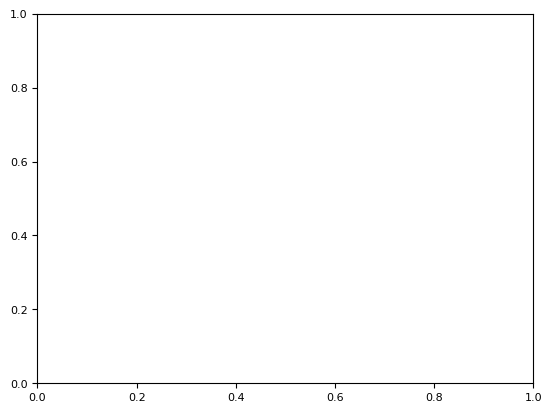

In [11]:
#Plotting

plt.plot(ds['time'], ds['dwLCL'], label = 'dw')
plt.plot(ds['time'], ds['dTLCL'], label='dT')
plt.plot(ds['time'], ds['LCL_wsn'], label='WLCL_new')
plt.xlabel('time (hours)')
plt.ylabel('variable')
plt.legend()

### Find the Convective Condensation Level (CCL) ###

To find the CCL, the average temperature and relative humidity between the lowest 50-100mbar levels are needed. This temperature can be used to calculate the staturated vapour pressure at temperature T. From this we can calculate the saturated water vapour mixing ratio at temperature T. Next, with the relative humidity the saturated water vapour mixing ratio at Td is calculated. For Td holds that the staturated water vapour mixing ratio is equal to the actual water vapour mixing ratio. The water vapour mixing ratio line can be plotted on the Skew T log P diagram and is then described by an equation T(P, W), a certain temperature at a certain pressure and W. The intersection of this line with the actual temperature profile then gives the height/pressure of the CCL. Getting the temperature at the same height gives TCCL. Calculating the potential temperature with respect to the surface then gives the convective temperature. comparing to the 2m temperature gives an indication on how much more energy is required to create convective clouds.

In [22]:
# Convectie Condensation Level (CCL) and gap wih Tc

### Calculate for each hour Tc, the gap between Tc and Ts (t2m)
dp['TP_mix'] = 273.15+(243.04*np.log(ds['ws_Td']*dp['level']*100/(610.94*(ds['ws_Td'] + eps))))/(17.625 - np.log(ds['ws_Td']*dp['level']*100/(610.94*(ds['ws_Td'] + eps))))  # Formula for the saturated water vapour mixing ratio line in a skew T log P (K).
ds['zCCL'] = xr.where(dp['TP_mix'] >= dp['t'], dp['z'], np.nan).min('level')  
ds['TCCL'] = xr.where(ds['zCCL'] == dp['z'], dp['t'], np.nan).min('level')  # get temperature at CCL and remove nans by taking min (K)
ds['PCCL'] = xr.where(dp['TP_mix'] >= dp['t'], dp['level'], np.nan).max('level')  # Take max because pressure decreases with height
ds['Tc'] = ds['TCCL'] * (ds['sp']/ds['PCCL'])**(287/1005.7)
ds['dTCCL'] = ds['Tc'] - ds['t2m']


### Moisture deficit ###

When the temperature at the surface does not reach the convective temperature, there are two options possible to reach it anyways. Add energy and increase the surface temperature or add moisture and increase the dew point temperature and water vapour mixing ratio.
To determine how much moisture should be added, we use the potential temperature profiles. First determine the potential temperature at the surface (which is just the t2m) and also the potential temperature profile from the pressrure levels. 
Now remember that the CCL is the intersect of the dry adiabat from the surface with the air tempereture and the water vapour mixing ratio line form the surface dewpoint. So by finding the intersect between the dry adiabat and the air temperature, we can define a new height for the CCL, assuming energy is not the limiting factor, but moisture is. From this height/pressure we can determine the temperature at this height. The temperature and pressure can then be used to calculate the saturated water vapour mixing ratio at this point. This is constant with height and thus also the W at d2m that would be needed to form clouds.

In [23]:
# Convective Condensation Level and moisture deficit

ds['zCCL_w'] = xr.where(ds['tht'] <= dp['tht'], dp['z'], np.nan).min('level')  # Height where potential temperature is equal as at surface
ds['TCCL_w'] = xr.where(ds['zCCL_w'] == dp['z'], dp['t'], np.nan).min('level') - 273.15
ds['PCCL_w'] = xr.where(ds['tht'] <= dp['tht'], dp['level'], np.nan).max('level')
# es_w = xr.where(zCCL_w == dp['z'], dp['es_T'], np.nan).min('level')  # slight difference between this one and the next one
ds['es_w'] = 610.94/1000 * np.exp(17.625 * ds['TCCL_w']/(ds['TCCL_w'] + 243.04))  # Saturated vapour pressure (kPa)
ds['ws_w'] = eps * ds['es_w']/(ds['PCCL_w']/10 - ds['es_w'])  # Saturated water vapour mixing ratio required to reach CCL if Tc = Ts
ds['dwCCL'] = ds['ws_w'] - ds['ws_Td']  # extra moisture required to reach CCL when assuming Tc = Ts
ds =ds.astype('float32')


In [24]:
ds

<xarray.Dataset>
Dimensions:    (time: 216)
Coordinates:
    longitude  float32 34.0
    latitude   float32 28.25
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-09T23:00:00
Data variables: (12/34)
    d2m        (time) float32 282.2 282.0 281.6 281.6 ... 279.5 278.3 278.3
    t2m        (time) float32 285.3 285.0 284.6 284.0 ... 285.6 284.0 283.9
    hcc        (time) float32 0.1197 0.1304 0.07648 ... 0.2465 0.08994 0.08731
    msl        (time) float32 1.014e+05 1.014e+05 ... 1.015e+05 1.015e+05
    sp         (time) float32 906.6 906.3 905.9 905.7 ... 908.5 908.2 907.6
    tcc        (time) float32 31.17 38.25 31.97 10.83 ... 95.18 75.2 41.07 40.2
    ...         ...
    zCCL_w     (time) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    TCCL_w     (time) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    PCCL_w     (time) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    es_w       (time) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    ws_w       (time) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dwCCL      (time) float32 dask.array<chunksize=(62,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-12 11:04:42 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [28]:
# Save the important variables to csv
np.errstate(overflow="ignore")
if month == 'Jan':
    # ds = ds.to_dataframe()
    # ds =ds.astype('float32')
    # dc = pd.DataFrame({'time': ds['time'], 'dwLCL': ds['dwLCL'], 'dTLCL': ds['dTLCL'], 'dTCCL': ds['dwCCL'], 'dwCCL': ds['dwCCL']})
    # ds = ds.sel(time, dwCCL, dwLCL, dTCCL, dTLCL)
    ds.to_netcdf("saved_on_disk.nc")
    
#     else:
#         dc = pd.DataFrame({'time': ds['time'], 'dwLCL': ds['dwLCL'], 'dTLCL': ds['dTLCL'], 'dwCCL': ds['dwCCL'], 'dwCCL': ds['dwCCL']})
#         dc.to_csv("Plotting_vars.csv", mode='a', index='False', header='False')


C:\Users\Maarten\anaconda3\envs\ame\Lib\site-packages\dask\array\chunk.py:278: RuntimeWarning: overflow encountered in cast
  return x.astype(astype_dtype, **kwargs)


MemoryError: Unable to allocate 153. MiB for an array with shape (141, 568974) and data type float16

In [14]:
dc.to_csv("Plotting_vars.csv", index='False')

In [29]:
d = []
d.append({'time': ds['time'], 'dwCCL': ds['dwCCL'], 'dwLCL': ds['dwLCL'], 
          'ws_Td': ds['ws_Td'], 'dTCCL': ds['dTCCL'],'dTLCL':ds['dTLCL'], 't2m': ds['t2m']-273.15})
d = ds.to_dataframe()
# pd.DataFrame(d)
print(d)

type: Unable to allocate 260. MiB for an array with shape (744, 20, 69, 133) and data type int16

type: Unable to allocate 260. MiB for an array with shape (744, 20, 69, 133) and data type int16

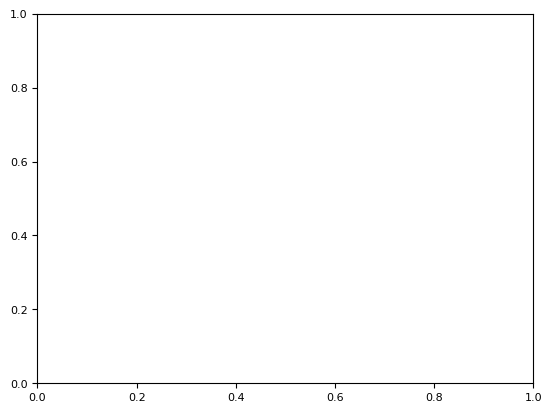

In [14]:
dc = ds['t2m']-273.15

plt.plot(ds['time'].dt.hour, ds['dwCCL'], label = 'dw to reach CCL')
plt.plot(ds['time'].dt.hour, ds['dwLCL'], label = 'dw to reach LCL')
plt.plot(ds['time'].dt.hour, ds['ws_Td'], label = 'actual 2m w')
plt.ylabel('Water vapour (g kg$^{-1}$)')
plt.xlabel('time (hours)')
plt.legend()
plt.show()
plt.plot(ds['time'].dt.hour, ds['dTCCL'], label='dT to reach CCL')
plt.plot(ds['time'].dt.hour, ds['dTLCL'], label = 'dT to reach LCL')
plt.plot(ds['time'].dt.hour, dc, label = 'actual 2m T')

plt.ylabel('Temperature (K)')
plt.xlabel('time (hours)')
# plt.plot(ds['time'].dt.hour, ds['ws_w'], label='wCCL_new')
# plt.plot(ds['time'].dt.hour, ds['Tc']-273.15, label = 'Tc')
plt.xlabel('time (hours)')
# plt.ylabel('variable')
plt.legend()
plt.show()

In [ ]:

# data from https://allisonhorst.github.io/palmerpenguins/

time = (ds['time'])
   
bins = np.arange(ds['dwLCL'].round(0).min()-0.5, ds['dwLCL'].round(0).max()+0.5, 0.5)
labels =  np.arange(ds['dwLCL'].round(0).min()-0.5, ds['dwLCL'].round(0).max(), 0.5)
db = ds.groupby_bins(ds['dwLCL'], bins, labels=labels).count(keep_attrs = 'True')

plt.hist(ds.dwCCL, bins=bins)


# weight_counts = db.dwCCL
# width = 0.5

# fig, ax = plt.subplots()
# bottom = np.zeros(24)

# for weight_count in weight_counts:
#     p = ax.bar(time, weight_count, width, label=labels, bottom=bottom)
#     bottom += weight_count

# ax.set_title("Number of penguins with above average body mass")
# ax.legend(loc="upper right")

# plt.show()

In [11]:
for time in ds.time.dt.hour:
    bins = np.arange(ds['dwLCL'][time].round(0).min()-0.5, ds['dwLCL'][time].round(0).max()+0.5, 0.5)
    labels =  np.arange(ds['dwLCL'][time].round(0).min()-0.5, ds['dwLCL'][time].round(0).max(), 0.5)
    db = ds.groupby_bins(ds['dwLCL'][time], bins, labels=labels, restore_coord_dims = 'True').count(keep_attrs = 'True')
    print(db.dwCCL.values)
#db = ds.groupby('time')
#db = ds.groupy_bins(ds['dwLCL'], bins, labels=labels, restore_coord_dims = 'True')

MemoryError: Unable to allocate 3.59 GiB for an array with shape (141, 6827688) and data type float32

In [82]:
print(ds.time.dt.hour)

<xarray.DataArray 'hour' (time: 24)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)
Coordinates:
    longitude  float32 33.75
    latitude   float32 30.25
  * time       (time) datetime64[ns] 2022-01-03 ... 2022-01-03T23:00:00


### Level of Free Convection (LFC) and (CCL) Equilibrium Level (EL) ###

The to complicate things. The level of free convection indicates the level form where a parcel moves gains positive buoyancy can travel highly into the atmosphere. This means deeper clouds, with lower temperatures in the cloud top. This is important for getting precipitating clouds. Clouds can either grow vertically by reaching their level of free convection (for which they first need to over come an energy barier called Convective Inhibition (CIN)) or by reaching their CCL. Both of these vertical growth mechanisms are borderd at the top by an Equilibrium level (EQ). The height difference between the convection level and the EL determines how high the cloud can be.

The LFC is found by following the moist adiabatic lapse rate from the LCL in the SkewT/LogP diagram, until it consides with the environmental lapse rate. The CCL we already determined. In case that the LCL is not reached by orographic lift and CCL is also not reached, we can add moisture to the system. Then we can determine how much we would need to reach the specific levels still anyways. Vegetation will add this moisture. So depending whether the LCL moisture deficit or the CCL moisture deficit is the largst, one of these two level will be reached first. So let's start determining which atmospheric level will be reached first.

In [92]:
from metpy.calc import lfc, cape_cin, parcel_profile
from metpy.units import units

#dp = dp.reindex(level=list(reversed(dp.level)))
#Td = Td.reindex(level=list(reversed(Td.level)))

print(dp['level'])
ds['PLFC'] = xr.zeros_like(ds['PCCL'])
ds['TLFC'] = xr.zeros_like(ds['TCCL'])
ds['CIN']  = xr.zeros_like(ds['TCCL'])
ds['CAPE'] = xr.zeros_like(ds['TCCL'])


for time in range(0, len(dp['time'])-1):
    #print(time)
    prof = parcel_profile(dp['level'] * units.hPa, dp['t'][time, 0] * units.K, Td[time, 0] * units.K)
    a = lfc(np.asarray(dp['level']) * units.hPa, np.asarray(dp['t'][time]) * units.K, np.asarray(Td[time]) * units.K)
    b = cape_cin(np.asarray(dp['level']) * units.hPa, np.asarray(dp['t'][time]) * units.K, np.asarray(Td[time]) * units.K, prof)
    ds['PLFC'][time] = a[0].magnitude
    ds['TLFC'][time] = a[1].magnitude
    ds['CIN'][time]  = b[0].magnitude
    ds['CAPE'][time]  = b[1].magnitude
ds['zLFC'] = xr.where(dp['level'] == ds['PLFC'], dp['level'], np.nan).max('level')

# for time in range(0, len(ds['time'])):
#     a = (metpy.calc.moist_lapse(dp['level'][time] * units.hPa, ds['TLCL'][time] * units.degC))
#     print(a.values)

<xarray.DataArray 'level' (level: 137)>
array([980., 975., 970., 965., 960., 955., 950., 945., 940., 935., 930., 925.,
       920., 915., 910., 905., 900., 895., 890., 885., 880., 875., 870., 865.,
       860., 855., 850., 845., 840., 835., 830., 825., 820., 815., 810., 805.,
       800., 795., 790., 785., 780., 775., 770., 765., 760., 755., 750., 745.,
       740., 735., 730., 725., 720., 715., 710., 705., 700., 695., 690., 685.,
       680., 675., 670., 665., 660., 655., 650., 645., 640., 635., 630., 625.,
       620., 615., 610., 605., 600., 595., 590., 585., 580., 575., 570., 565.,
       560., 555., 550., 545., 540., 535., 530., 525., 520., 515., 510., 505.,
       500., 495., 490., 485., 480., 475., 470., 465., 460., 455., 450., 445.,
       440., 435., 430., 425., 420., 415., 410., 405., 400., 395., 390., 385.,
       380., 375., 370., 365., 360., 355., 350., 345., 340., 335., 330., 325.,
       320., 315., 310., 305., 300.])
Coordinates:
  * level      (level) float64 980.0 975

C:\Users\Josie\anaconda3\envs\hydrometeo\Lib\site-packages\dask\array\core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
C:\Users\Josie\anaconda3\envs\hydrometeo\Lib\site-packages\dask\array\core.py:1713: FutureWarning: The `numpy.place` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
C:\Users\Josie\anaconda3\envs\hydrometeo\Lib\site-packages\dask\array\core.py:1713: FutureWarning: The `numpy.copyto` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
C:\Users\Josie\anaconda3\envs\hydrometeo\Lib

IndexError: Index 24 is out of bounds for axis 0 with size 24

In [96]:
print(ds['CAPE'].values)

[  0.          0.          0.          0.          0.          0.
   0.          0.         -8.619345   -9.07018    -3.7156131  -5.536482
  -5.187782   -7.9542975  -8.952681   -9.909749  -11.559243  -10.931891
 -11.251697  -11.540773  -12.151146  -13.550502  -20.757841  -23.58758  ]


In [23]:
# Determine which moisture deficit is the largest:

# Determine the moist adiabat
from scipy.integrate import quad
def integrand(P, eps, es, Lv, Rd, T, cpd, cpv, Rm):
    return lambda P, es, Lv, T: (P-es/(Rd*T) + es/Rm*T)**-1 * (1 + eps * es/(P-es)*(1+(Lv * eps * es/(P-es))/Rd*T))/(cpd + eps*es/(P-es) * cpv + (Lv**2 * eps *es/(P-es)*(eps + eps*es/(P-es)))/Rd*T**2)

P = dp['level']
T = dp['t']
es = dp['es_T']
Lv = (-6.14342e-5 * T**3 + 1.58927e-3 * T**2 -2.36418 * T + 2500.79)*1000
Rd = 287.1  # J kg-1 K-1
cpd = 1003.85 #J kg-1 K
cpv = 1820 #J kg-1 K
Rm = 461.5  # J kg-1 K-1
# moistT = dp.apply_ufunc(integrand, )
moistT, err = xr.apply_ufunc(quad(integrand, ds['sp'], dp['level'], args=(eps, es, Lv, Rd, T, cpd, cpv, Rm)))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Find the Level of Free Convection ###

For the LFC we need to find the first point where the dewpoint temperature is equal to the environmental temperature. We do not have a Td profile, so use alternatively, follow the moist adiabat from the LCL until we reach a point where the moist adiabat temperature == the environmental temperature. 

In [63]:
Gamm = 6/1000  # K m-1
ztop = 9000
# dj.insert(0,"Tmoist", " ")
for time in range(0, len(dj.TCCL.values)):
    z = dj.CCL.values[time]
    z = np.arange(z, ztop, 1)
    a = [dj['TCCL'].values[time] - Gamm*(i - dj['CCL'].values[time]) for i in z]
    print(a)
    dj.at[time, 'Tmoist'] = a
    print(dj['Tmoist'])
# dg = xr.Dataset.from_dataframe(dj)
print(dg)
dj['LFC'] = (np.nan).where(dj['Tmoist'])
# dj['LFC'] = dj.loc[dj['Tmoist'] == dp['t']]

# df['col'] = (value_if_false).where(condition, value_if_true)

print(dj)

[-0.813812255859375, -0.819812255859375, -0.825812255859375, -0.831812255859375, -0.837812255859375, -0.843812255859375, -0.849812255859375, -0.855812255859375, -0.861812255859375, -0.867812255859375, -0.873812255859375, -0.8798122558593751, -0.8858122558593751, -0.891812255859375, -0.897812255859375, -0.903812255859375, -0.909812255859375, -0.915812255859375, -0.921812255859375, -0.927812255859375, -0.933812255859375, -0.939812255859375, -0.945812255859375, -0.951812255859375, -0.957812255859375, -0.963812255859375, -0.969812255859375, -0.975812255859375, -0.981812255859375, -0.987812255859375, -0.9938122558593749, -0.9998122558593749, -1.005812255859375, -1.011812255859375, -1.017812255859375, -1.023812255859375, -1.029812255859375, -1.035812255859375, -1.041812255859375, -1.047812255859375, -1.053812255859375, -1.059812255859375, -1.065812255859375, -1.071812255859375, -1.077812255859375, -1.083812255859375, -1.089812255859375, -1.095812255859375, -1.101812255859375, -1.107812255859

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'latitude', 'longitude', 'time'}

In [40]:
print(dt)

     level                time  longitude  latitude             d   cc   
0      300 2022-01-03 11:00:00      33.75      31.0  2.479045e-05  0.0  \
1      300 2022-01-03 14:00:00      33.75      31.0  1.210967e-05  0.0   
2      300 2022-01-03 15:00:00      33.75      31.0  1.113248e-05  0.0   
3      300 2022-01-03 16:00:00      33.75      31.0  7.871383e-06  0.0   
4      300 2022-01-03 19:00:00      33.75      31.0 -8.665361e-07  0.0   
..     ...                 ...        ...       ...           ...  ...   
175   1000 2022-01-03 19:00:00      33.75      31.0 -4.476066e-05  0.0   
176   1000 2022-01-03 20:00:00      33.75      31.0 -3.739763e-05  0.0   
177   1000 2022-01-03 21:00:00      33.75      31.0 -1.895596e-05  0.0   
178   1000 2022-01-03 22:00:00      33.75      31.0  4.473934e-06  0.0   
179   1000 2022-01-03 23:00:00      33.75      31.0  1.668884e-05  0.0   

               z          r  ciwc  clwc         q  crwc  cswc           t   
0    9261.449219  23.486961   0.0 

In [42]:
np.arange(0, len(dj.TCCL.values))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# Moist adiabatic lapse rate 
Gamm = 6/1000  # K m-1
ztop = 19000
# z = np.arange(0, ztop, 1)

for level in range(0, len(dj.TCCL.values)):
    z = dj.CCL.values[level]
    z = np.arange(z, ztop, 1)
    T = dj.TCCL.values[level]
    T = T - Gamm * z
    LFC = pd.DataFrame({'z': z, 'T':T})
#     for ind in LFC.index:
#         lift = xr.where(round(LFC.iloc[ind, 1], 2) == dp.t.round(2) , 1, 0)
        
#         print(lift)
#     Lift = xr.where(dp.z == LFC.z and dp.t == LFC.T, 1, 0)
    print(LFC)
    print(T)
#     LFC[T] = T - Gamm * z
#     a = xr.where(dj.T == LFC[T])
#     print(a)
print(LFC)


In [ ]:
a = LFC.T.round(2).isin(dp.t.round(2))